##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Better performance with `tf.data`

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

GPUs and TPUs can radically reduce the time required to execute a single training step.
Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
The `tf.data` API helps to build flexible and efficient input pipelines.
This document demonstrates how to use the `tf.data` API's features for building highly performant TensorFlow input pipelines.

Before you continue, you should have read and understood the "[Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)" guide, to know how to use the `tf.data` API.

## Setup

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import time
import timeit
import itertools

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Resources

* [Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* `tf.data.Dataset` API

## Optimize performance

To exhibit how performance can be optimized, you will improve a naive example.

First, define a data generator simulating time elapsed to download and read a file from disk.

In [490]:
def generator_ds(file_start=0):
    """Return a new `tf.data.Dataset`.
    Samples returned by the dataset are of the form:
        ((step,), (t0, d), (f, c, i))
    where:
        - step is the step name
        - t0 is the timestamp when step started
        - d is the time spent in the step
        - f is the dataset/file index
        - c is the dateset calls index (number of times the files has been read)
        - i is the sample index
    """
    call_counters = defaultdict(itertools.count)
    def generator(file_num):
        call_num = next(call_counters[file_num])
        tf.print("Generator", file_num, "yielding samples with value", call_num)
        load_enter = time.perf_counter()
        time.sleep(0.03)  # (Down)loading file in memory
        load_elapsed = time.perf_counter() - load_enter
        for i in range(3):
            prepare_enter = time.perf_counter()
            time.sleep(0.015)  # Fetching a single "line" from file
            prepare_elapsed = time.perf_counter() - prepare_enter
            if i <= 0:
                yield (
                    [["load"], ["prepare"]],
                    [[load_enter, load_elapsed], [prepare_enter, prepare_elapsed]],
                    [(file_num, call_num, i), (file_num, call_num, i)]
                )
            else:
                yield (
                    [["prepare"]],
                    [[prepare_enter, prepare_elapsed]],
                    [(file_num, call_num, i)]
                )
            

    file_counter = itertools.count(file_start)
    while True:
        file_id = next(file_counter)
        ds = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int64),
            output_shapes=([None, 1], [None, 2], [None, 3]),
            args = (tf.constant(file_id, dtype=tf.dtypes.int64),)
        )
        yield ds

_root_generator = generator_ds()
def get_dataset():
    ds = next(_root_generator)
    return ds

Then, define a simple "training" loop, simulating the time elapsed to run a single step.

In [401]:
def iterate(ds, num_epochs=tf.constant(2, dtype=tf.dtypes.int64)):
    steps = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values = tf.zeros([0, 3], dtype=tf.dtypes.int64)
    start_time = time.perf_counter()
    for epoch_num in tf.data.Dataset.range(num_epochs):
        epoch_enter = time.perf_counter()
        for (dataset_steps, dataset_times, sample) in ds:
            steps = tf.concat((steps, dataset_steps), axis=0)
            times = tf.concat((times, dataset_times), axis=0)
            values = tf.concat((values, sample), axis=0)
            
            train_enter = time.perf_counter()
            time.sleep(0.01)
            steps = tf.concat((steps, [["train"]]), axis=0)
            times = tf.concat((times, [(train_enter, time.perf_counter() - train_enter)]), axis=0)
            values = tf.concat((values, tf.expand_dims(sample[-1], 0)), axis=0)
            
        steps = tf.concat((steps, [["epoch"]]), axis=0)
        times = tf.concat((times, [(epoch_enter, time.perf_counter() - epoch_enter)]), axis=0)
        values = tf.concat((values, [[epoch_num, -1, -1]]), axis=0)
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps, "times": times, "values": values}

Define a function to plot a timeline of the pipeline steps.

In [404]:
def draw_timeline(timeline, title="Naive", width=0.5):
    steps = timeline['steps'].numpy()
    times = timeline['times'].numpy()
    values = timeline['values'].numpy()
    metrics = np.unique(steps)
    start = times[:,0].min()
    
    cmap = mpl.cm.get_cmap("plasma")
    fig, axs = plt.subplots(len(metrics), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, 4.0)
    plt.xlim(start-0.01, start+width)
            
    for i, metric in enumerate(metrics):
        metric_str = metric.decode()
        ax = axs[i]
        ax.set_ylabel(metric_str)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time")
        serie = times[np.squeeze(steps==metric)]
        annotations = values[np.squeeze(steps==metric)]
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(metrics)), alpha=0.66)
        for j, (start, width) in enumerate(serie):
            ax.text(start + width/2, 0.33*((j%2)+1), f"{metric_str} {j}\n{annotations[j]}".capitalize(),
                    horizontalalignment='center', verticalalignment='center')

### The naive approach

Now you are ready to track your performance improvements.

Start by a naive pipeline with no tricks, iterating over your dataset as-is.

Generating new dataset
Generator 13 yielding samples with value 0
Generator 13 yielding samples with value 1
Execution time: 0.3064716660010163


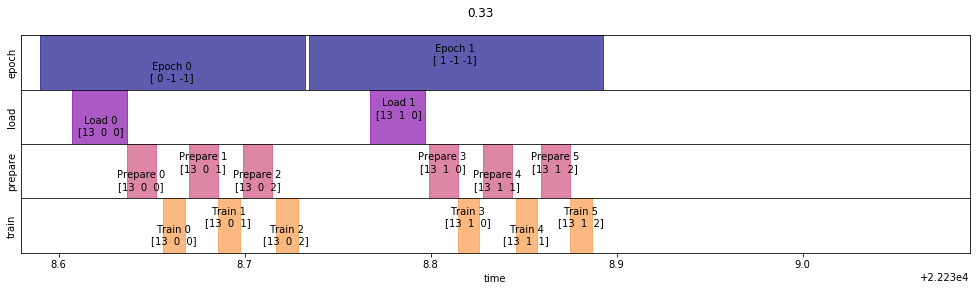

In [405]:
draw_timeline(iterate(get_dataset()), 0.33)

The next section builds on this input pipeline, illustrating best practices for designing performant TensorFlow input pipelines.

### Pipelining

To perform a training step, you must first extract and transform the training
data and then feed it to a model running on an accelerator. However, in a naive
synchronous implementation, while the CPU is preparing the data, the accelerator
is sitting idle. Conversely, while the accelerator is training the model, the
CPU is sitting idle. The training step time is thus the sum of both CPU
pre-processing time and the accelerator training time.

**Pipelining** overlaps the preprocessing and model execution of a training
step. While the accelerator is performing training step `N`, the CPU is
preparing the data for step `N+1`. Doing so reduces the step time to the maximum
(as opposed to the sum) of the training and the time it takes to extract and
transform the data.

The `tf.data` API provides a software pipelining mechanism through the
`tf.data.Dataset.prefetch` transformation, which can be used to decouple the
time when data is produced from the time when data is consumed. In particular,
the transformation uses a background thread and an internal buffer to prefetch
elements from the input dataset ahead of the time they are requested. The number
of elements to prefetch should be equal to (or possibly greater than) the number
of batches consumed by a single training step. You could either manually tune
this value, or set it to `tf.data.experimental.AUTOTUNE` which will prompt the
`tf.data` runtime to tune the value dynamically at runtime.

To apply this change to your pipeline, add the `prefetch` call as the last transformation of your input pipeline.

Note that the prefetch transformation provides benefits any time there is an
opportunity to overlap the work of a "producer" with the work of a "consumer."

In [406]:
def get_prefetched_dataset():
    return get_dataset().prefetch(tf.data.experimental.AUTOTUNE)

Generating new dataset
Generator 14 yielding samples with value 0
Generator 14 yielding samples with value 1
Execution time: 0.2181181599989941


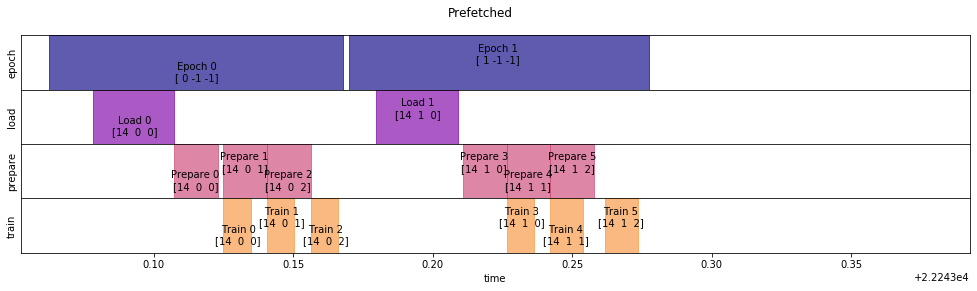

In [407]:
draw_timeline(iterate(get_prefetched_dataset()), "Prefetched", 0.33)

### Parallelize data transformation

When preparing data, input elements may need to be pre-processed. To this
end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which
applies a user-defined function to each element of the input dataset. Because input elements are
independent of one another, the pre-processing can be parallelized across
multiple CPU cores. To make this possible, the `map` transformation provides the
`num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your
hardware, characteristics of your training data (such as its size and shape),
the cost of your map function, and what other processing is happening on the CPU
at the same time; a simple heuristic is to use the number of available CPU
cores. For instance, if the machine executing the example above had 4 cores, it
would have been more efficient to set `num_parallel_calls=4`. On the other hand,
setting `num_parallel_calls` to a value much greater than the number of
available CPUs can lead to inefficient scheduling, resulting in a slowdown.
Similar to the `prefetch` transformation, the `map` transformation supports
`tf.data.experimental.AUTOTUNE` which will delegate the decision about what
level of parallelism to use to the tf.data runtime.

In [408]:
def mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.02)
        map_elapsed = time.perf_counter() - map_enter
        return (
            tf.concat((steps, [["map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

In [409]:
def get_naive_map_dataset():
    return get_dataset().map(mapped_function)

def get_parallel_map_dataset():
    return get_dataset().map(mapped_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Generating new dataset
Generator 15 yielding samples with value 0
Generator 15 yielding samples with value 1
Execution time: 0.4461405649999506
Generating new dataset
Generator 16 yielding samples with value 0
Generator 16 yielding samples with value 1
Execution time: 0.2635126739987754


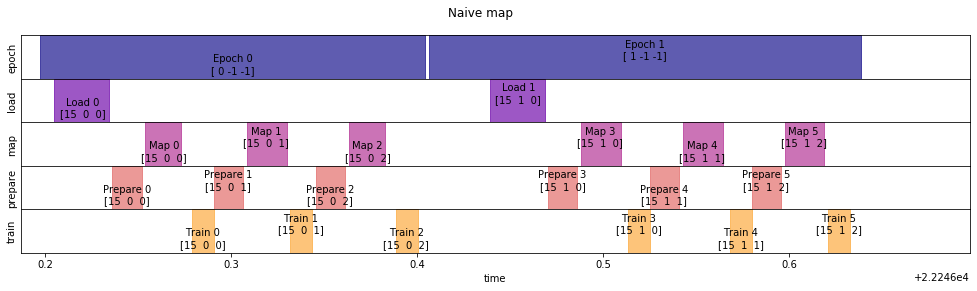

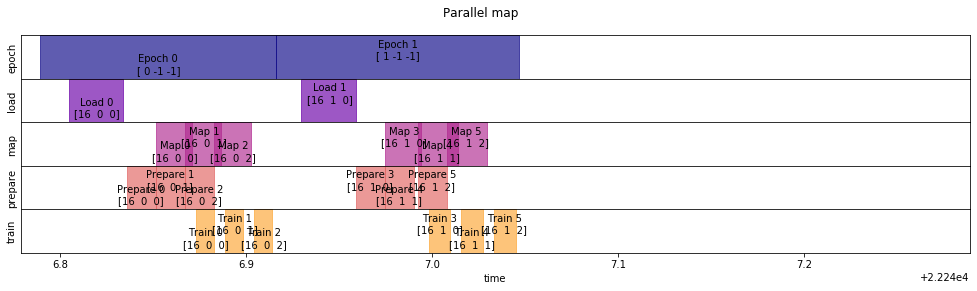

In [410]:
draw_timeline(iterate(get_naive_map_dataset()), "Naive map")
draw_timeline(iterate(get_parallel_map_dataset()), "Parallel map")

### Parallelize data extraction

In a real-world setting, the input data may be stored remotely (for example, GCS
or HDFS), either because the input data would not fit locally or because the
training is distributed and it would not make sense to replicate the input data
on every machine. A dataset pipeline that works well when reading data locally
might become bottlenecked on I/O when reading data remotely because of the
following differences between local and remote storage:

*   **Time-to-first-byte:** Reading the first byte of a file from remote storage
    can take orders of magnitude longer than from local storage.
*   **Read throughput:** While remote storage typically offers large aggregate
    bandwidth, reading a single file might only be able to utilize a small
    fraction of this bandwidth.

In addition, once the raw bytes are read into memory, it may also be necessary
to deserialize and/or decrypt the data (e.g.
[protobuf](https://developers.google.com/protocol-buffers/)), which requires
additional computation. This overhead is present irrespective of whether the
data is stored locally or remotely, but can be worse in the remote case if data
is not prefetched effectively.

To mitigate the impact of the various data extraction overheads, the
`tf.data.Dataset.interleave` transformation can be used to parallelize the data
extraction step, interleaving the contents of other datasets (such as data file
readers). The number of datasets to overlap can be specified by the
`cycle_length` argument, while the level of parallelism can be specified by the
`num_parallel_calls` argument. Similar to the `prefetch` and `map`
transformations, the `interleave` transformation supports
`tf.data.experimental.AUTOTUNE` which will delegate the decision about what
level of parallelism to use to the tf.data runtime.

The following diagram illustrates the effect of supplying `cycle_length=2` and
`num_parallel_calls=2` to the `interleave` transformation:

![parallel io](https://www.tensorflow.org/images/datasets_parallel_io.png)

To apply this change to our running example, replace the call to `TFRecordDataset` by a call to `interleave`.

In [505]:
def _eager_get_dataset(file_start):
    def _gen(i):
        for x in next(generator_ds(i)):
            yield x
    return tf.data.Dataset.from_generator(
        _gen,
        output_types=(tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int64),
        args=[file_start]
    )

def get_multifile_map_dataset():
    return tf.data.Dataset.range(2).flat_map(_eager_get_dataset)

def get_multifile_interleave_dataset():
    return tf.data.Dataset.range(2).interleave(_eager_get_dataset)

def get_multifile_interleave_parallel_dataset():
    return tf.data.Dataset.range(2).interleave(_eager_get_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Execution time: 0.7606287499984319
Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Execution time: 0.750043561001803
Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Generator 0 yielding samples with value 0
Generator 1 yielding samples with value 0
Execution time: 0.4410532520014385


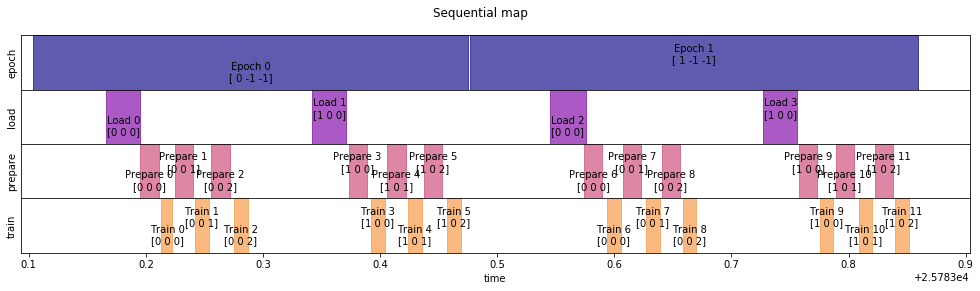

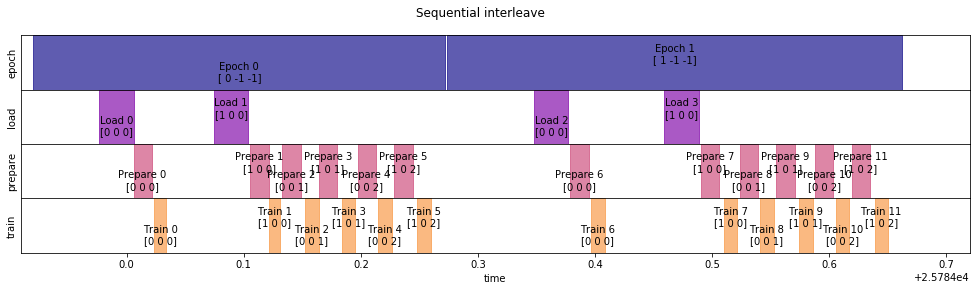

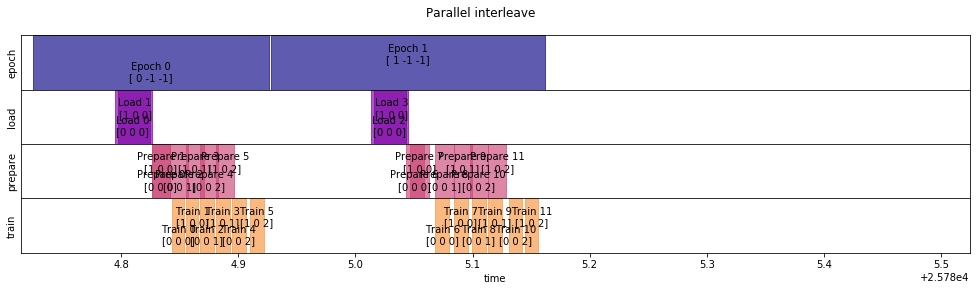

In [515]:
tl1 = iterate(get_multifile_map_dataset())
tl2 = iterate(get_multifile_interleave_dataset())
tl3 = iterate(get_multifile_interleave_parallel_dataset())
draw_timeline(tl1, "Sequential map", 0.8)
draw_timeline(tl2, "Sequential interleave", 0.8)
draw_timeline(tl3, "Parallel interleave", 0.8)

## Performance considerations

The `tf.data` API is designed around composable transformations to provide its
users with flexibility. Although many of these transformations are commutative,
the ordering of certain transformations has performance implications.

### Map and batch

Invoking the user-defined function passed into the `map` transformation has
overhead related to scheduling and executing the user-defined function.
We recommend vectorizing the user-defined function (that is, have it operate
over a batch of inputs at once) and apply the `batch` transformation _before_
the `map` transformation.

To apply this change to our running example, define a new parsing function,
acting on a batch of serialized examples, and call it after batching our dataset.

In [14]:
def parse_batch_and_augment_fn(examples):
    """ Parse a batch of TFExample records and perform simple data augmentation."""
    example_features = {
        "image": tf.io.FixedLenFeature((), tf.string, ""),
        "label": tf.io.FixedLenFeature((), tf.int64, -1)
    }
    
    # Call the vectorized version of examples parsing
    parsed = tf.io.parse_example(examples, example_features)
    images = tf.map_fn(tf.io.decode_image, parsed['image'], dtype=tf.dtypes.uint8)  # tf.io.decode_image is not vectorized and cannot decode a batch of images

    images = _augment_helper(images)
    return images, parsed["label"]

In [15]:
def make_dataset():
    dataset = tf.data.Dataset.list_files(os.path.join(temp_dir.name, 'tf_record.*'))
    dataset = dataset.interleave(
        tf.data.TFRecordDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # Batch the dataset before calling map
    dataset = dataset.batch(64)  # => Dataset of batches of tuples
    
    dataset = dataset.map(
        parse_batch_and_augment_fn,  # Call the vectorized parsing function
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [16]:
tf.print("Batch before map: ", timeit.timeit(lambda: iterate(make_dataset()), number=1))

Batch before map:  7.158265191999817


### Map and memory bound operations

A number of transformations, including `interleave`, `prefetch`, and `shuffle`,
maintain an internal buffer of elements. If the user-defined function passed
into the `map` transformation changes the size of the elements, then the
ordering of the map transformation and the transformations that buffer elements
affects the memory usage. In general, we recommend choosing the order that
results in lower memory footprint, unless different ordering is desirable for
performance.

The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory
or on local storage. If the user-defined function passed into the `map`
transformation is expensive, apply the cache transformation after the `map`
transformation as long as the resulting dataset can still fit into memory or
local storage. If the user-defined function increases the space required to
store the dataset beyond the cache capacity, consider pre-processing your data
before your training job to reduce resource usage.

In our running example, the mapped function decode a PNG string to a tensor of pixels.
This can increase the size of the data significantly.

In [17]:
serialized_example = next(iter(
    tf.data.TFRecordDataset(tf.data.Dataset.list_files(os.path.join(temp_dir.name, 'tf_record.*')))
))
import sys
tf.print("Serialized example:", len(serialized_example.numpy()))
parsed_example = tf.io.parse_single_example(serialized_example,{"image": tf.io.FixedLenFeature((), tf.string, ""), "label": tf.io.FixedLenFeature((), tf.int64, -1)})
tf.print("Parsed example:", len(parsed_example["image"].numpy()) + 4)
decoded_example = (tf.io.decode_image(parsed_example["image"]), parsed_example["label"])
tf.print("Decoded example:", tf.size(decoded_example[0]) + 4)

Serialized example: 393
Parsed example: 359
Decoded example: 772


A tradeoff could be to split our parsing function.

In a first step, you load data from disk and parse the TFExample.
Cache at this step to avoid disk-read on next iterations.
Add a second step which decode our PNG, inflating memory consumption.

In [18]:
def parse_batch_fn(examples):
    """ Parse a batch of TFExample records."""
    example_features = {
        "image": tf.io.FixedLenFeature((), tf.string, ""),
        "label": tf.io.FixedLenFeature((), tf.int64, -1)
    }
    
    parsed = tf.io.parse_example(examples, example_features)
    return parsed["image"], parsed["label"]

def decode_and_augment(images, labels):
    return (
        _augment_helper(
            tf.map_fn(tf.io.decode_image, images, dtype=tf.dtypes.uint8)
        ),
        labels
    )

In [19]:
def make_dataset():
    dataset = tf.data.Dataset.list_files(os.path.join(temp_dir.name, 'tf_record.*'))
    dataset = dataset.interleave(
        tf.data.TFRecordDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    dataset = dataset.batch(64)
    
    # Parse TFExamples
    dataset = dataset.map(
        parse_batch_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    # Cache the resulting dataset
    dataset = dataset.cache()
    # Decode images
    dataset = dataset.map(
        decode_and_augment,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [20]:
tf.print("Cache: ", timeit.timeit(lambda: iterate(make_dataset()), number=1))

Cache:  6.041410915000597


### Repeat and shuffle

The `tf.data.Dataset.repeat` transformation repeats the input data a finite (or
infinite) number of times; each repetition of the data is typically referred to
as an _epoch_. The `tf.data.Dataset.shuffle` transformation randomizes the order
of the dataset's examples.

If the `repeat` transformation is applied before the `shuffle` transformation,
then the epoch boundaries are blurred. That is, certain elements can be repeated
before other elements appear even once. On the other hand, if the `shuffle`
transformation is applied before the repeat transformation, then performance
might slow down at the beginning of each epoch related to initialization of the
internal state of the `shuffle` transformation. In other words, the former
(`repeat` before `shuffle`) provides better performance, while the latter
(`shuffle` before `repeat`) provides stronger ordering guarantees.


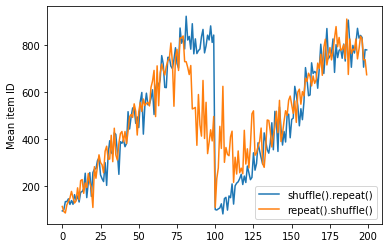

In [21]:
range_ds = tf.data.Dataset.range(1000)
shuffle_repeat = [x.numpy().mean() for x in range_ds.shuffle(200).repeat(2).batch(10)]
repeat_shuffle = [x.numpy().mean() for x in range_ds.repeat(2).shuffle(200).batch(10)]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Best practice summary

Here is a summary of the best practices for designing performant TensorFlow
input pipelines:

*   Use the `prefetch` transformation to overlap the work of a producer and
    consumer. In particular, we recommend adding `prefetch` to the end of your
    input pipeline to overlap the transformations performed on the CPU with the
    training done on the accelerator. Either manually tuning the buffer size, or
    using `tf.data.experimental.AUTOTUNE` to delegate the decision to the
    `tf.data` runtime.
*   Parallelize the `map` transformation by setting the `num_parallel_calls`
    argument. Either manually tuning the level of parallelism, or using
    `tf.data.experimental.AUTOTUNE` to delegate the decision to the `tf.data`
    runtime.
*   If you are working with data stored remotely and / or requiring
    deserialization, we recommend using the `interleave` transformation to
    parallelize the reading (and deserialization) of data from different files.
*   Vectorize user-defined functions passed in to the `map` transformation
    to amortize the overhead associated with scheduling and executing the
    function.
*   If your data can fit into memory, use the `cache` transformation to cache it
    in memory during the first epoch, so that subsequent epochs can avoid the
    overhead associated with reading, parsing, and transforming it.
*   If your pre-processing increases the size of your data, we recommend
    applying the `interleave`, `prefetch`, and `shuffle` first (if possible) to
    reduce memory usage.
*   We recommend applying the `shuffle` transformation _before_ the `repeat`
    transformation.